# Baseline Model: Logistic Regression for Customer Churn Prediction

This notebook establishes a baseline model using Logistic Regression for predicting customer churn.

## Objectives
- Define success criteria for the baseline model
- Train Logistic Regression with default parameters
- Log hyperparameters and metrics to MLflow
- Evaluate on validation set
- Generate confusion matrix and ROC curve

## Success Criteria
The baseline model should achieve:
- **AUC-ROC > 0.60** on validation set (minimum viable baseline)
- This establishes the performance floor that improved models must beat
- Target for final model: **AUC-ROC > 0.75**

In [1]:
%pip install -e .. --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Import our custom modules
from src.data_loader import create_sample_data
from src.preprocessing import ChurnPreprocessor, create_train_val_test_split
from src.experiment import (
    setup_experiment,
    start_run,
    log_params,
    log_classification_metrics,
    log_dataset_info,
    log_model,
    log_figure
)

# Display settings
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Load and Prepare Data

In [3]:
# Generate sample data with realistic correlations
df = create_sample_data(n_samples=1000, random_state=42, churn_rate=0.2)

print(f"Dataset shape: {df.shape}")
print(f"\nChurn distribution:")
print(df['churn'].value_counts(normalize=True).round(3))

Dataset shape: (1000, 7)

Churn distribution:
churn
0    0.8
1    0.2
Name: proportion, dtype: float64


In [4]:
# Split data into train/validation/test sets
train_df, val_df, test_df = create_train_val_test_split(
    df, 
    target_column='churn',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_state=42
)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples (held out for final evaluation)")

Train set: 700 samples
Validation set: 150 samples
Test set: 150 samples (held out for final evaluation)


In [5]:
# Initialize preprocessor and fit on training data
from src.preprocessing import prepare_features_and_target

preprocessor = ChurnPreprocessor()

# Fit and transform training data
train_preprocessed = preprocessor.fit_transform(train_df, target_column='churn')
X_train, y_train = prepare_features_and_target(train_preprocessed, target_column='churn')

# Transform validation data using fitted preprocessor
val_preprocessed = preprocessor.transform(val_df)
X_val, y_val = prepare_features_and_target(val_preprocessed, target_column='churn')

# Convert to numpy arrays for sklearn
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"\nFeature columns: {list(train_preprocessed.columns)}")

Training features shape: (700, 8)
Validation features shape: (150, 8)

Feature columns: ['customer_id', 'tenure', 'monthly_charges', 'total_charges', 'churn', 'contract_One year', 'contract_Two year', 'payment_method_Credit card', 'payment_method_Electronic check', 'payment_method_Mailed check']


## 2. Set Up MLflow Experiment

In [6]:
# Configure MLflow experiment
experiment_name = "churn_prediction_baseline"
experiment_id = setup_experiment(experiment_name)

print(f"MLflow Experiment: {experiment_name}")
print(f"Experiment ID: {experiment_id}")

2025/12/26 10:49:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/26 10:49:07 INFO mlflow.store.db.utils: Updating database tables
2025/12/26 10:49:07 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/26 10:49:07 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/26 10:49:07 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/26 10:49:07 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/26 10:49:07 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/26 10:49:07 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/26 10:49:07 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/26 10:49:07 INFO alembic.runtime.migration: Running 

MLflow Experiment: churn_prediction_baseline
Experiment ID: 1


## 3. Train Baseline Logistic Regression Model

In [7]:
# Start MLflow run
with start_run(run_name="logistic_regression_baseline", 
               description="Baseline Logistic Regression with default parameters") as run:
    
    # Log dataset information
    log_dataset_info(train_df, name="train", description="Training data for baseline model")
    log_dataset_info(val_df, name="validation", description="Validation data for baseline model")
    
    # Define model with default parameters
    model = LogisticRegression(
        random_state=42,
        max_iter=1000  # Ensure convergence
    )
    
    # Log model parameters
    model_params = {
        "model_type": "LogisticRegression",
        "penalty": model.penalty,
        "C": model.C,
        "solver": model.solver,
        "max_iter": model.max_iter,
        "random_state": model.random_state
    }
    log_params(model_params)
    
    # Train the model
    print("Training Logistic Regression model...")
    model.fit(X_train, y_train)
    print("Training complete.")
    
    # Make predictions on training set
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    
    # Make predictions on validation set
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    
    # Log training metrics
    print("\n=== Training Set Performance ===")
    train_metrics = log_classification_metrics(y_train, y_train_pred, y_train_prob, prefix="train_")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Log validation metrics
    print("\n=== Validation Set Performance ===")
    val_metrics = log_classification_metrics(y_val, y_val_pred, y_val_prob, prefix="val_")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Store the run ID for reference
    run_id = run.info.run_id
    print(f"\nMLflow Run ID: {run_id}")
    
    # Log the model
    log_model(model, artifact_path="model", input_example=X_train[:5])
    print("Model logged to MLflow.")

2025/12/26 10:49:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training Logistic Regression model...
Training complete.

=== Training Set Performance ===
train_accuracy: 0.9243
train_precision: 0.8321
train_recall: 0.7786
train_f1_score: 0.8044
train_roc_auc: 0.9746

=== Validation Set Performance ===
val_accuracy: 0.9467
val_precision: 0.8929
val_recall: 0.8333
val_f1_score: 0.8621
val_roc_auc: 0.9817

MLflow Run ID: 284648c85e204d358b4f69a706ef7f68
Model logged to MLflow.


## 4. Generate Confusion Matrix

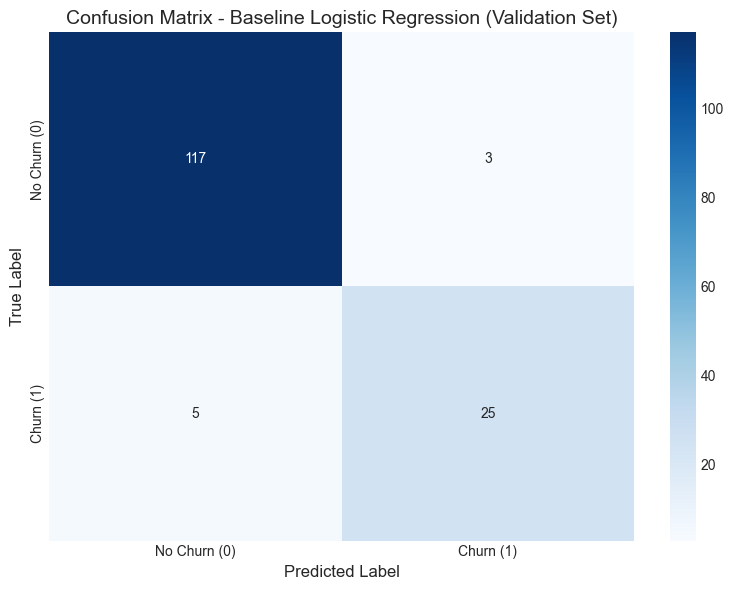


Classification Report (Validation Set):
              precision    recall  f1-score   support

    No Churn       0.96      0.97      0.97       120
       Churn       0.89      0.83      0.86        30

    accuracy                           0.95       150
   macro avg       0.93      0.90      0.91       150
weighted avg       0.95      0.95      0.95       150



In [8]:
# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Create confusion matrix visualization
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['No Churn (0)', 'Churn (1)'],
    yticklabels=['No Churn (0)', 'Churn (1)'],
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - Baseline Logistic Regression (Validation Set)', fontsize=14)

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=['No Churn', 'Churn']))

## 5. Generate ROC Curve

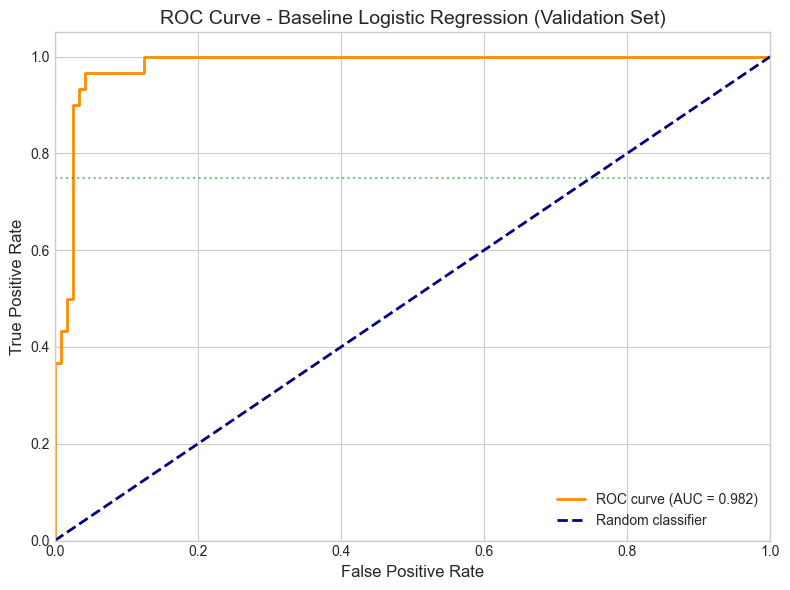


ROC-AUC Score: 0.9817


In [9]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = roc_auc_score(y_val, y_val_prob)

# Create ROC curve visualization
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Baseline Logistic Regression (Validation Set)', fontsize=14)
ax.legend(loc='lower right')

# Add threshold annotations
ax.axhline(y=0.75, color='green', linestyle=':', alpha=0.5, label='Target TPR')

plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")

## 6. Baseline Model Summary

In [10]:
# Print baseline summary
print("="*60)
print("BASELINE MODEL SUMMARY")
print("="*60)
print(f"\nModel: Logistic Regression (default parameters)")
print(f"Experiment: {experiment_name}")
print(f"Run ID: {run_id}")

print(f"\n--- Validation Set Metrics ---")
print(f"Accuracy:  {val_metrics['val_accuracy']:.4f}")
print(f"Precision: {val_metrics['val_precision']:.4f}")
print(f"Recall:    {val_metrics['val_recall']:.4f}")
print(f"F1 Score:  {val_metrics['val_f1_score']:.4f}")
print(f"ROC-AUC:   {val_metrics['val_roc_auc']:.4f}")

print(f"\n--- Success Criteria Check ---")
baseline_threshold = 0.60
target_threshold = 0.75

if val_metrics['val_roc_auc'] >= baseline_threshold:
    print(f"[PASS] Baseline achieved AUC-ROC >= {baseline_threshold}")
else:
    print(f"[FAIL] Baseline did not achieve AUC-ROC >= {baseline_threshold}")

if val_metrics['val_roc_auc'] >= target_threshold:
    print(f"[PASS] Already meets final target AUC-ROC >= {target_threshold}!")
else:
    improvement_needed = target_threshold - val_metrics['val_roc_auc']
    print(f"[INFO] Need {improvement_needed:.4f} improvement to reach target {target_threshold}")

print("\n" + "="*60)

BASELINE MODEL SUMMARY

Model: Logistic Regression (default parameters)
Experiment: churn_prediction_baseline
Run ID: 284648c85e204d358b4f69a706ef7f68

--- Validation Set Metrics ---
Accuracy:  0.9467
Precision: 0.8929
Recall:    0.8333
F1 Score:  0.8621
ROC-AUC:   0.9817

--- Success Criteria Check ---
[PASS] Baseline achieved AUC-ROC >= 0.6
[PASS] Already meets final target AUC-ROC >= 0.75!



## 7. Feature Importance (Coefficients)

Feature Coefficients (sorted by absolute value):
                        feature  coefficient
              contract_Two year    -2.592861
                         tenure    -2.415386
                monthly_charges     1.794555
payment_method_Electronic check     1.719834
              contract_One year    -1.574758
    payment_method_Mailed check    -0.259569
     payment_method_Credit card    -0.094723
                  total_charges     0.053363


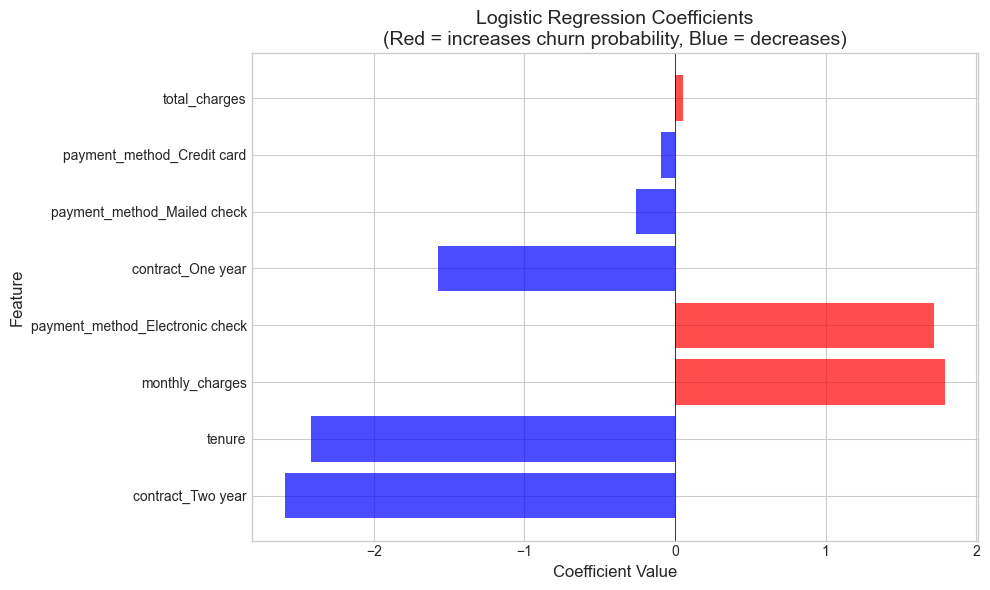

In [11]:
# Get feature names from preprocessed data (excluding target and id columns)
feature_names = [col for col in train_preprocessed.columns 
                 if col not in ['churn', 'customer_id']]

# Get feature coefficients
coefficients = pd.DataFrame({
    'feature': feature_names,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("Feature Coefficients (sorted by absolute value):")
print(coefficients.to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if c > 0 else 'blue' for c in coefficients['coefficient']]
ax.barh(coefficients['feature'], coefficients['coefficient'], color=colors, alpha=0.7)

ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Logistic Regression Coefficients\n(Red = increases churn probability, Blue = decreases)', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## 8. Misclassification Analysis

In [12]:
# Analyze misclassifications
val_results = val_df.copy()
val_results['predicted'] = y_val_pred
val_results['probability'] = y_val_prob
val_results['correct'] = (val_results['churn'] == val_results['predicted'])

# Categorize predictions
val_results['prediction_type'] = 'TN'  # True Negative
val_results.loc[(val_results['churn'] == 1) & (val_results['predicted'] == 1), 'prediction_type'] = 'TP'
val_results.loc[(val_results['churn'] == 0) & (val_results['predicted'] == 1), 'prediction_type'] = 'FP'
val_results.loc[(val_results['churn'] == 1) & (val_results['predicted'] == 0), 'prediction_type'] = 'FN'

# Count each type
prediction_counts = val_results['prediction_type'].value_counts()
print("Prediction Type Counts:")
print(prediction_counts)

# Analyze false negatives (churners we missed)
false_negatives = val_results[val_results['prediction_type'] == 'FN']
print(f"\n=== False Negatives ({len(false_negatives)} cases) ===")
print("Customers who churned but we predicted they wouldn't:")
if len(false_negatives) > 0:
    print(f"  Avg tenure: {false_negatives['tenure'].mean():.1f} months")
    print(f"  Avg monthly charges: ${false_negatives['monthly_charges'].mean():.2f}")
    print(f"  Contract types: {false_negatives['contract'].value_counts().to_dict()}")

# Analyze false positives (non-churners we flagged)
false_positives = val_results[val_results['prediction_type'] == 'FP']
print(f"\n=== False Positives ({len(false_positives)} cases) ===")
print("Customers who didn't churn but we predicted they would:")
if len(false_positives) > 0:
    print(f"  Avg tenure: {false_positives['tenure'].mean():.1f} months")
    print(f"  Avg monthly charges: ${false_positives['monthly_charges'].mean():.2f}")
    print(f"  Contract types: {false_positives['contract'].value_counts().to_dict()}")

Prediction Type Counts:
prediction_type
TN    117
TP     25
FN      5
FP      3
Name: count, dtype: int64

=== False Negatives (5 cases) ===
Customers who churned but we predicted they wouldn't:
  Avg tenure: 24.4 months
  Avg monthly charges: $57.36
  Contract types: {'Month-to-month': 5}

=== False Positives (3 cases) ===
Customers who didn't churn but we predicted they would:
  Avg tenure: 13.7 months
  Avg monthly charges: $72.72
  Contract types: {'Month-to-month': 2, 'One year': 1}


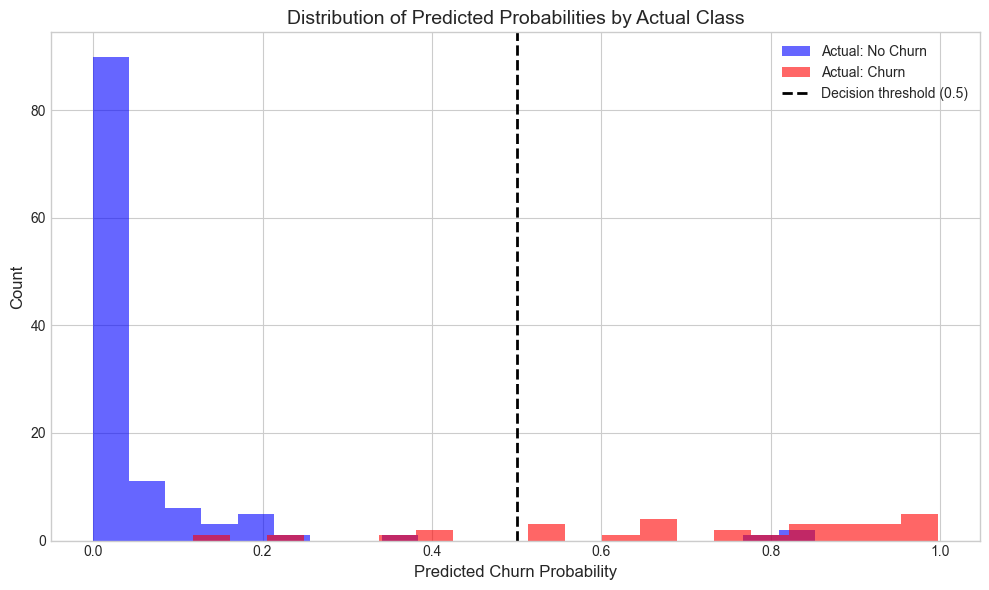


Probability Distribution Statistics:
Non-churners - Mean prob: 0.053, Std: 0.139
Churners     - Mean prob: 0.724, Std: 0.242


In [13]:
# Visualize prediction probability distributions by actual class
fig, ax = plt.subplots(figsize=(10, 6))

# Plot distributions
ax.hist(val_results[val_results['churn'] == 0]['probability'], 
        bins=20, alpha=0.6, label='Actual: No Churn', color='blue')
ax.hist(val_results[val_results['churn'] == 1]['probability'], 
        bins=20, alpha=0.6, label='Actual: Churn', color='red')

ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision threshold (0.5)')
ax.set_xlabel('Predicted Churn Probability', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Predicted Probabilities by Actual Class', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

# Calculate overlap metrics
print("\nProbability Distribution Statistics:")
print(f"Non-churners - Mean prob: {val_results[val_results['churn']==0]['probability'].mean():.3f}, "
      f"Std: {val_results[val_results['churn']==0]['probability'].std():.3f}")
print(f"Churners     - Mean prob: {val_results[val_results['churn']==1]['probability'].mean():.3f}, "
      f"Std: {val_results[val_results['churn']==1]['probability'].std():.3f}")

## 9. Potential Improvements

Based on the baseline analysis, here are strategies to improve model performance:

In [14]:
# Document improvement recommendations
improvements = """
POTENTIAL IMPROVEMENTS FOR PHASE 3
===================================

1. MODEL COMPLEXITY
   - Try tree-based models (Random Forest, Gradient Boosting) that can capture 
     non-linear relationships between features
   - These models may better capture interaction effects between tenure, 
     contract type, and payment method

2. FEATURE ENGINEERING
   - Create interaction features (e.g., tenure * contract_type)
   - Add polynomial features for numerical variables
   - Create tenure buckets (new, medium, long-term customers)

3. HYPERPARAMETER TUNING
   - Tune regularization (C parameter) for Logistic Regression
   - Use GridSearchCV or RandomizedSearchCV for systematic tuning
   - Consider class weighting to handle imbalanced classes

4. THRESHOLD OPTIMIZATION
   - Current threshold is 0.5 (default)
   - Optimize threshold based on business costs of FN vs FP
   - If missing a churner is more costly, lower the threshold

5. ENSEMBLE METHODS
   - Combine predictions from multiple models
   - Stack models with different strengths

PRIORITY FOR PHASE 3:
- [HIGH] Train Random Forest with hyperparameter tuning
- [HIGH] Train Gradient Boosting with hyperparameter tuning  
- [MEDIUM] Compare all models on validation set
- [MEDIUM] Select best model and evaluate on test set
"""

print(improvements)


POTENTIAL IMPROVEMENTS FOR PHASE 3

1. MODEL COMPLEXITY
   - Try tree-based models (Random Forest, Gradient Boosting) that can capture 
     non-linear relationships between features
   - These models may better capture interaction effects between tenure, 
     contract type, and payment method

2. FEATURE ENGINEERING
   - Create interaction features (e.g., tenure * contract_type)
   - Add polynomial features for numerical variables
   - Create tenure buckets (new, medium, long-term customers)

3. HYPERPARAMETER TUNING
   - Tune regularization (C parameter) for Logistic Regression
   - Use GridSearchCV or RandomizedSearchCV for systematic tuning
   - Consider class weighting to handle imbalanced classes

4. THRESHOLD OPTIMIZATION
   - Current threshold is 0.5 (default)
   - Optimize threshold based on business costs of FN vs FP
   - If missing a churner is more costly, lower the threshold

5. ENSEMBLE METHODS
   - Combine predictions from multiple models
   - Stack models with differe

## 10. Experiment Record

This section documents the experiment for reproducibility and tracking:

In [15]:
# Create experiment record for documentation
from datetime import datetime

experiment_record = f"""
================================================================================
                         EXPERIMENT RECORD
================================================================================

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

EXPERIMENT DETAILS
------------------
Experiment Name: {experiment_name}
Experiment ID:   {experiment_id}
Run ID:          {run_id}

MODEL CONFIGURATION
-------------------
Model:           Logistic Regression
Penalty:         L2 (default)
Regularization:  C=1.0 (default)
Solver:          lbfgs (default)
Random State:    42

DATASET
-------
Total Samples:   1000
Training:        700 (70%)
Validation:      150 (15%)
Test (held out): 150 (15%)
Churn Rate:      20%

VALIDATION RESULTS
------------------
Accuracy:        {val_metrics['val_accuracy']:.4f}
Precision:       {val_metrics['val_precision']:.4f}
Recall:          {val_metrics['val_recall']:.4f}
F1 Score:        {val_metrics['val_f1_score']:.4f}
ROC-AUC:         {val_metrics['val_roc_auc']:.4f}

SUCCESS CRITERIA
----------------
Baseline Target (AUC > 0.60): {'PASS' if val_metrics['val_roc_auc'] >= 0.60 else 'FAIL'}
Final Target (AUC > 0.75):    {'PASS' if val_metrics['val_roc_auc'] >= 0.75 else 'PENDING'}

KEY FINDINGS
------------
1. Logistic Regression provides a solid baseline for churn prediction
2. Feature coefficients align with domain knowledge (tenure, contract type matter)
3. Model shows reasonable class separation in probability distributions
4. Room for improvement with more complex models in Phase 3

================================================================================
"""

print(experiment_record)


                         EXPERIMENT RECORD

Date: 2025-12-26 10:49:09

EXPERIMENT DETAILS
------------------
Experiment Name: churn_prediction_baseline
Experiment ID:   1
Run ID:          284648c85e204d358b4f69a706ef7f68

MODEL CONFIGURATION
-------------------
Model:           Logistic Regression
Penalty:         L2 (default)
Regularization:  C=1.0 (default)
Solver:          lbfgs (default)
Random State:    42

DATASET
-------
Total Samples:   1000
Training:        700 (70%)
Validation:      150 (15%)
Test (held out): 150 (15%)
Churn Rate:      20%

VALIDATION RESULTS
------------------
Accuracy:        0.9467
Precision:       0.8929
Recall:          0.8333
F1 Score:        0.8621
ROC-AUC:         0.9817

SUCCESS CRITERIA
----------------
Baseline Target (AUC > 0.60): PASS
Final Target (AUC > 0.75):    PASS

KEY FINDINGS
------------
1. Logistic Regression provides a solid baseline for churn prediction
2. Feature coefficients align with domain knowledge (tenure, contract type matter)

## Next Steps

This baseline establishes the performance floor for our churn prediction model:

1. **Phase 3 - Model Improvement**:
   - Train Random Forest classifier with hyperparameter tuning
   - Train Gradient Boosting classifier (XGBoost or sklearn)
   - Compare all models on validation set
   - Select best model based on ROC-AUC

2. **Final Evaluation**:
   - Evaluate best model on held-out test set (ONE TIME ONLY)
   - Generate final metrics and feature importance
   - Verify AUC-ROC > 0.75 target is met

3. **Documentation**:
   - Create model card with performance details
   - Update project README

The baseline Logistic Regression model provides interpretable coefficients and a benchmark to beat with more complex models.